# Matching the WEST ICRH Antenna

In this notebook we investigate the various method to match a WEST ICRH antenna. By matching the antenna we mean to find 4 capacitances values $C_1$, $C_2$, $C_3$ and $C_4$ in order for the antenna to be operated at a given frequency $f_0$. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import skrf as rf
import numpy as np
import sys
from tqdm.notebook import tqdm

sys.path.append('..')
from west_ic_antenna import WestIcrhAntenna

In [3]:
rf.stylely()

In [4]:
from west_ic_antenna import WestIcrhAntenna

## Matching Each Sides Separately
Here, each side of the antenna is matched separatly, which leads to two set of capacitances $(C_1, C_2)$ and $(C_3,C_4)$.

In the following example, both sides of the antenna are matched at the frequency $f_0$, keeping opposite side unmatched (C=150pF):

In [7]:
f0 = 55.5e6
freq = rf.Frequency(54.5, 56.5, npoints=1001, unit='MHz')
ant = WestIcrhAntenna(frequency=freq)  # default is vacuum coupling

In [8]:
C_match_left = ant.match_one_side(f_match=f0, side='left', solution_number=1)
C_match_right = ant.match_one_side(f_match=f0, side='right', solution_number=1)
print('Left side matching point: ', C_match_left)
print('Right side matching point: ', C_match_right)

True solution #1: [49.96759955 47.93907206]
True solution #1: [49.73848215 48.10011089]
Left side matching point:  [49.967599548873835, 47.93907205854311, 150, 150]
Right side matching point:  [150, 150, 49.738482149208544, 48.10011089414825]


Let's have a look to the RF reflection coefficient of each sides:

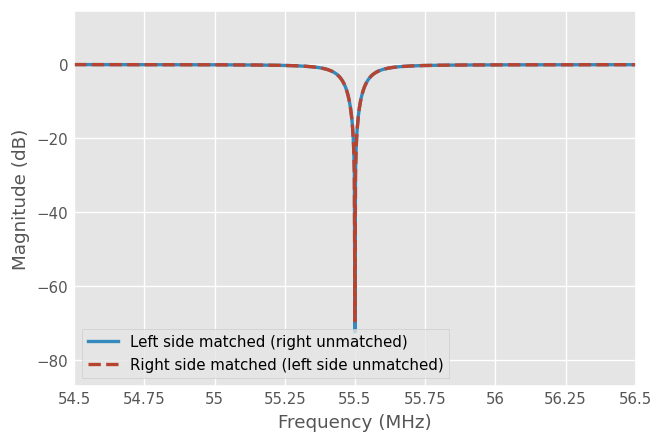

In [9]:
fig, ax = plt.subplots()
ant.circuit(Cs=C_match_left).network.plot_s_db(m=0, n=0, lw=2, ax=ax)
ant.circuit(Cs=C_match_right).network.plot_s_db(m=1, n=1, lw=2, ls='--', ax=ax)
ax.legend(('Left side matched (right unmatched)', 
           'Right side matched (left side unmatched)'))

In reality, the precision at which one can tune the capacitance is not better than 1/100 pF, so one have to consider rounding optimal solutions to such precision :


In [10]:
C_match_left = ant.match_one_side(f_match=f0, side='left', solution_number=1, decimals=2)
C_match_right = ant.match_one_side(f_match=f0, side='right', solution_number=1, decimals=2)
print('Left side matching point: ', C_match_left)
print('Right side matching point: ', C_match_right)

True solution #1: [49.96759964 47.93907245]
Rounded result: [49.97, 47.94, 150.0, 150.0]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [49.73848167 48.10011115]
Rounded result: [150.0, 150.0, 49.74, 48.1]
Left side matching point:  [49.97, 47.94, 150.0, 150.0]
Right side matching point:  [150.0, 150.0, 49.74, 48.1]


Note that the performances are slightly degraded, but, it's real life! 

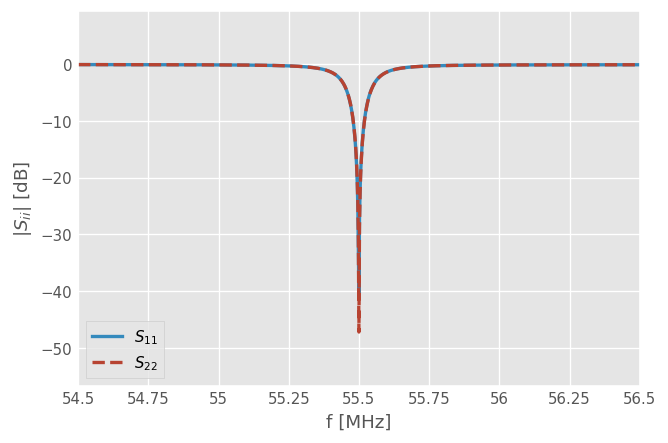

In [11]:
fig, ax = plt.subplots()
ant.circuit(Cs=C_match_left).network.plot_s_db(m=0, n=0, lw=2, ax=ax)
ant.circuit(Cs=C_match_right).network.plot_s_db(m=1, n=1, lw=2, ls='--', ax=ax)
ax.legend(('Left side matched (right unmatched)', 
           'Right side matched (left side unmatched)'))
ax.set_ylabel('$|S_{ii}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{11}$', '$S_{22}$'))

## Frequency Shift for Dipole Excitation
The coupling between antenna's sides requires shifting the frequency with respect to the matching frequency used for each side separately.

Thus, if the optimal capacitor set for both side are of the same kind (i.e. either both C_top>C_bot or both C_top<C_bot), then dipole excitation (phase $(0,\pi)$) requires to shift the frequency to higher frequency to operate the antenna in a optimal conditions:

In [12]:
# dipole excitation
power = [1, 1]
phase = [0, rf.pi]
# combine both separate solutions
C_match = [C_match_left[0], C_match_left[1], C_match_right[2], C_match_right[3]]
# looking to the active s parameters:
s_act = ant.s_act(power, phase, Cs=C_match)
# finding the optimum frequency
idx_f_opt = np.argmin(np.abs(s_act[:,0]))
f_opt = freq.f[idx_f_opt]
delta_f = f_opt - f0
print(f'Optimum frequency is f_opt={f_opt/1e6} MHz --> {delta_f/1e6} MHz shift' )

Optimum frequency is f_opt=55.728 MHz --> 0.228 MHz shift


Text(0.5, 1.0, 'Dipole excitation')

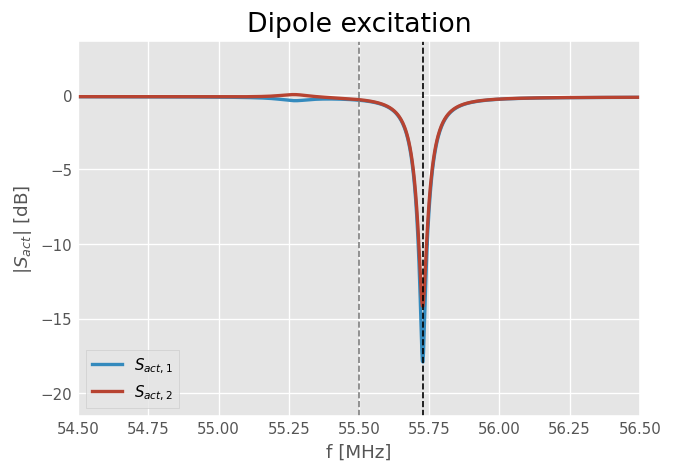

In [13]:
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.axvline(f_opt/1e6, ls='--', color='k')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))
ax.set_title('Dipole excitation')

However, the reflection coefficient is not that low (-15 to -20 dB at best). That means that there is certainly a sweeter spot of the capacitor set.

In [14]:
C_opt = ant.match_both_sides(f_match=55.728e6, decimals=2)
print(C_opt)

Looking for individual solutions separately for 1st guess...
True solution #1: [49.30690682 47.31824748]
Rounded result: [49.31, 47.32, 150.0, 150.0]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [49.07962386 47.47779344]
Rounded result: [150.0, 150.0, 49.08, 47.48]
Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
True solution #1: [49.87563114 48.04904444 49.55481102 48.25487323]
Rounded result: [49.88, 48.05, 49.55, 48.25]
[49.88, 48.05, 49.55, 48.25]


The difference is:

In [18]:
np.array(C_opt) - np.array(C_match)

array([-0.09,  0.11, -0.19,  0.15])

That is, one should:
- decrease slightly the top capacitors
- increase slightly the bottom capacitors

As a rule of thumb, at 55.5 MHz, we can remember to do -0.1pF for top and +0.1pF for bottom capacitors. Doing, so, we get a better match point (between -20 and -30 dB)

Text(0.5, 1.0, 'Dipole excitation')

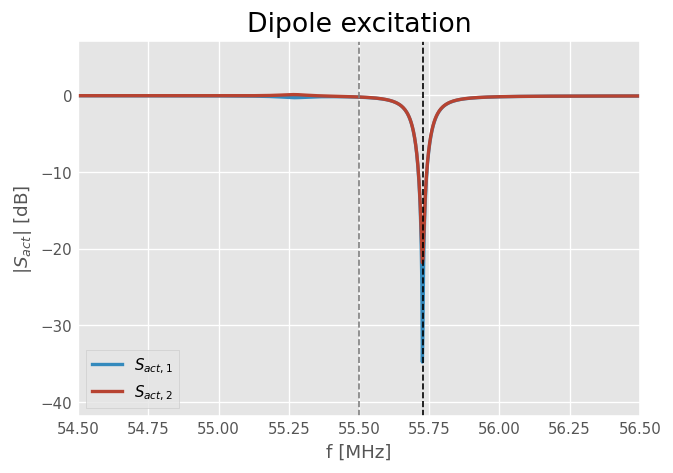

In [20]:
C_match_improved = [C_match[0] - 0.1,
                    C_match[1] + 0.1,
                    C_match[2] - 0.1,
                    C_match[3] + 0.1]
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, ant.s_act_db(Cs=C_match_improved, power=[1,1], phase=[0,np.pi]), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.axvline(f_opt/1e6, ls='--', color='k')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))
ax.set_title('Dipole excitation')

Monopole excitation (phase $(0,0)$) at the contrary requires shifting the operating frequency toward lower frequencies:

In [21]:
# monopole excitation
power = [1, 1]
phase = [0, 0]
# combine both separate solutions
C_match = [C_match_left[0], C_match_left[1], C_match_right[2], C_match_right[3]]
# looking to the active s parameters:
s_act = ant.s_act(power, phase, Cs=C_match)
# finding the optimum frequency
idx_f_opt = np.argmin(np.abs(s_act[:,0]))
f_opt = freq.f[idx_f_opt]
delta_f = f_opt - f0
print(f'Optimum frequency is f_opt={f_opt/1e6} MHz --> {delta_f/1e6} MHz shift' )

Optimum frequency is f_opt=55.27 MHz --> -0.23 MHz shift


Text(0.5, 1.0, 'Monopole excitation')

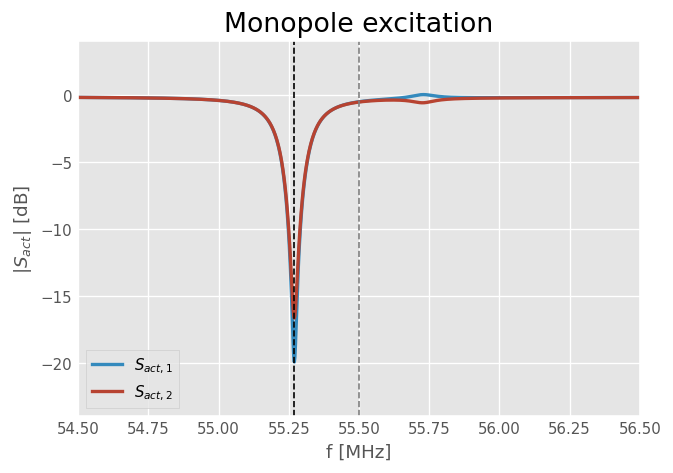

In [23]:
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.axvline(f_opt/1e6, ls='--', color='k')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))
ax.set_title('Monopole excitation')

The matching can also be improved:

In [26]:
C_opt_mono = ant.match_both_sides(f_match=55.27e6, decimals=2, power=[1,1], phase=[0,0])
print(C_opt_mono)

Looking for individual solutions separately for 1st guess...
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [29.95534337 29.95534337]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [50.6416654  48.57244674]
Rounded result: [50.64, 48.57, 150.0, 150.0]
True solution #1: [50.41067506 48.73500811]
Rounded result: [150.0, 150.0, 50.41, 48.74]
Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
True solution #1: [50.06507201 47.82371932 49.8891473  47.9801226 ]
Rounded result: [50.07, 47.82, 49.89, 47.98]
[50.07, 47.82, 49.89, 47.98]


So a difference of:

In [27]:
np.array(C_opt_mono) - np.array(C_match)

array([ 0.1 , -0.12,  0.15, -0.12])

That is the opposite trend than for dipole:
- increase slightly top capacitors (~ +0.1 pF as a rule of thumb)
- decrease slightly bot capacitors (~ -0.1 pF as a rule of thumb)

## Matching Both Sides at the same time
It is also possible to optimize the antenna directly for the target frequency and for a given excitation. Matching both sides at the same time in fact matches each side separately, then find the optimum points using these solutions as starting point to help the convergence of the optimization.

Two methods are available to match both sides of the antenna: `match_both_sides` which use the NumPy optimisation routines, and `match_both_sides_iterative` which uses the feedback matching algorithm (see [matching_automatic.ipynb](matching_automatic.ipynb) for more details). The primer is more robust in finding a solution, eventually at the price of a longer calculation. The later method can indeed be "lost" if the ideal solution is not close enough (or if the optimal region is too narrow, like under vacuum).

In [ ]:
f0 = 55e6
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')
ant = WestIcrhAntenna(frequency=freq)  # default is vacuum coupling

# antenna excitation to match for
power = [1, 1]  # W
phase = [0, np.pi]  # dipole

ant.DEBUG=True  # display additional messages
# Providing an initial guess C0 skip the search on both sides separately
C0 = [C_match_left[0], C_match_left[1], C_match_right[2], C_match_right[3]]
C_opt_vacuum_dipole = ant.match_both_sides(f_match=f0, power=power, phase=phase, C0=C0, decimals=2)

In [ ]:
f0 = 55e6
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')
ant = WestIcrhAntenna(frequency=freq)  # default is vacuum coupling

# looking to the active s parameters:
s_act = ant.s_act(power, phase, Cs=C_opt_vacuum_dipole)

In [ ]:
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))

# Manual Matching on Plasma
When the antenna is facing the plasma, the coupling resistance increases and the antenna matching is affected.

If the operator keeps the matchpoint obtained on vacuum (in dipole for example), the antenna will have the following behaviour:

In [ ]:
# changing the front-face of the antenna to a plasma case
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')
front_face_plasma = WestIcrhAntenna.interpolate_front_face(Rc=1, source='TOPICA-L-mode')
ant = WestIcrhAntenna(frequency=freq, front_face=front_face_plasma)  

# looking to the active s parameters in dipole:
powers = [1 ,1]
phases = [0, np.pi] 
s_act = ant.s_act(powers, phases , Cs=C_opt_vacuum_dipole)

fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))
ax.set_title('Reflection on plasma using vacuum matching setpoint')

Thus, it is necessary to re-adapt the capacitors to improve the matching of the antenna on plasma:

In [ ]:
C_match_plasma = ant.match_both_sides(f0, power=powers, phase=phases, C0=C_opt_vacuum_dipole)

In [ ]:
s_act = ant.s_act(powers, phases , Cs=C_match_plasma)

fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))
ax.set_title('Reflection on plasma after rematching')

If we compare the differences between capacitances setpoint between vacuum and plasma cases, we see that the difference between the values go like this:
* top capacitances are increased 
* bottom capacitances are decreased

Thus, the "distance" between top and bottom capacitance is increased. 

In [ ]:
np.array(C_match_plasma) - np.array(C_opt_vacuum_dipole)

The capacitance shift to apply with respect to the vacuum setpoint depends of the coupling resistance of the plasma.

We can use this property to deduce the set of capacitors to use during plasma operation. Below we generate a series of various plasma loading cases, of increasing coupling resistance $R_c$. For each case we search for and we store the setpoints.

In [ ]:
C_matchs = []

# note: on plasma loads, the iterative method is faster
# important : increase the gap between capacitances start point for the algorith to converge for high Rc cases
C0 = np.array(C_opt_vacuum_dipole) + np.array([+5, -5, +5, -5]) 

Rcs1 = np.linspace(0.39, 1.7, 10)  # TOPICA "H-mode" (low coupling)
for Rc in tqdm(Rcs1):
    _plasma = WestIcrhAntenna.interpolate_front_face(Rc=Rc, source='TOPICA-H-mode')
    _ant = WestIcrhAntenna(frequency=freq, front_face=_plasma)
    _C_match = _ant.match_both_sides_iterative(f0, power=powers, phase=phases, Cs=C_opt_vacuum_dipole)
    C_matchs.append(_C_match)


Rcs2 = np.linspace(1, 2.9, 10)  # TOPICA "L-mode" (higher coupling)
for Rc in tqdm(Rcs2):
    _plasma = WestIcrhAntenna.interpolate_front_face(Rc=Rc, source='TOPICA-L-mode')
    _ant = WestIcrhAntenna(frequency=freq, front_face=_plasma)
    _C_match = _ant.match_both_sides_iterative(f0, power=powers, phase=phases, Cs=C0)
    C_matchs.append(_C_match)

Let's plot the average capacitance shift to apply versus the coupling resistance of the plasma loading scenario:

In [ ]:
Rcs3 = np.linspace(0.3, 1.6, 10)

In [ ]:
diff_C = np.array(C_matchs) - np.array(C_opt_vacuum_dipole)

In [ ]:
Rcs=np.concatenate([Rcs1, Rcs2])
fig, ax = plt.subplots()
ax.plot(Rcs, diff_C, 'o')
ax.set_xlabel('Coupling Resistance $R_c$ [Ohm]')
ax.set_ylabel('Capacitance Shift $\Delta C$ [pF]')
ax.set_title('Capacitance Shift to add from Vacuum Match Points (55 MHz)')
ax.legend(['Left Top', 'Left Bot', 'Right Top', 'Right Bot'])

# Automatic Matching
Here is just a glimpse of the automatic matching capabilities.


Let's assume we start from a non-optimal situation, that is we enlarge the capacitance differences from a vacuum matching from a rather arbitrary value: 

In [ ]:
Cs=list(np.array(C_opt_vacuum_dipole) + np.array([+3, -3, +3, -3]))

Then, using the capacitor predictor, we calculate the capacitance set to reach:

In [ ]:
# Evaluate this cell a few times to see the convergence to the optimal matching
C_left, C_right, err = ant.capacitor_predictor(powers, phases, Cs=Cs)
idx_f = np.argmin(np.abs(ant.frequency.f - 55e6))
Cs=[*C_left[idx_f], *C_right[idx_f]]

print(Cs)

s_act = ant.s_act(powers, phases , Cs=Cs)

fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))
ax.set_title('Reflection on plasma after rematching')

This plot should be benchmark against plasma measurements.

In [ ]:
from IPython.core.display import HTML
def _set_css_style(css_file_path):
    """
    Read the custom CSS file and load it into Jupyter
    Pass the file path to the CSS file
    """
    styles = open(css_file_path, "r").read()
    s = '<style>%s</style>' % styles
    return HTML(s)

_set_css_style('custom.css')